<a href="https://colab.research.google.com/github/Fake-Review-Detection-Spiill-AI/screnario-2---multi-task/blob/main/draft-04-multitask-multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library


In [ ]:

!pip install Sastrawi
!pip install swifter
!pip install emoji
import pandas as pd
import numpy as np
import re
import emoji
import string
import seaborn as sns
import matplotlib.pyplot as plt
import swifter
from sklearn.utils import resample
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Loading Essential libraries
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False # this to force autocompletion

# Dataset

In [122]:
df = pd.read_csv('https://raw.githubusercontent.com/Fake-Review-Detection-Spiill-AI/screnario-2---multi-task/main/draft02_dataset_review_pribadi.csv',)
df.head()

,username,rate,date,label,sentimen,reviews,produk
0,ziaprlfauzi,4,21-05-2024 03:08 AM,fake,positive,Suka banget pake emina ini dr jaman kuliah sam...,Emina Sunscreen
1,mnisfa,4,20-05-2024 04:13 PM,fake,positive,sunscreen yang ringan banget\r\nengga lengket ...,Emina Sunscreen
2,amandabilla98,4,20-05-2024 07:33 AM,trusted,positive,"sunscreen jaman kuliah, cari nya gampang ada d...",Emina Sunscreen
3,mtraandita,3,19-05-2024 01:36 PM,trusted,neutral,"Waktu smp aku pakai ss ini selama ±2 tahun, te...",Emina Sunscreen
4,Miftahuljahra,2,18-05-2024 06:38 AM,trusted,negative,Aku ga terlalu cocok pake produk ini terlebih ...,Emina Sunscreen


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2394 entries, 0 to 2393
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  2394 non-null   object
 1   rate      2394 non-null   int64 
 2   date      2394 non-null   object
 3   label     2394 non-null   object
 4   sentimen  2394 non-null   object
 5   reviews   2394 non-null   object
 6   produk    2394 non-null   object
dtypes: int64(1), object(6)
memory usage: 131.0+ KB


# EDA

In [124]:
df['text_length'] = df['reviews'].apply(len)
df.text_length.describe()

count    2394.000000
mean      256.362573
std       163.333404
min         1.000000
25%       137.250000
50%       250.000000
75%       319.000000
max      1472.000000
Name: text_length, dtype: float64

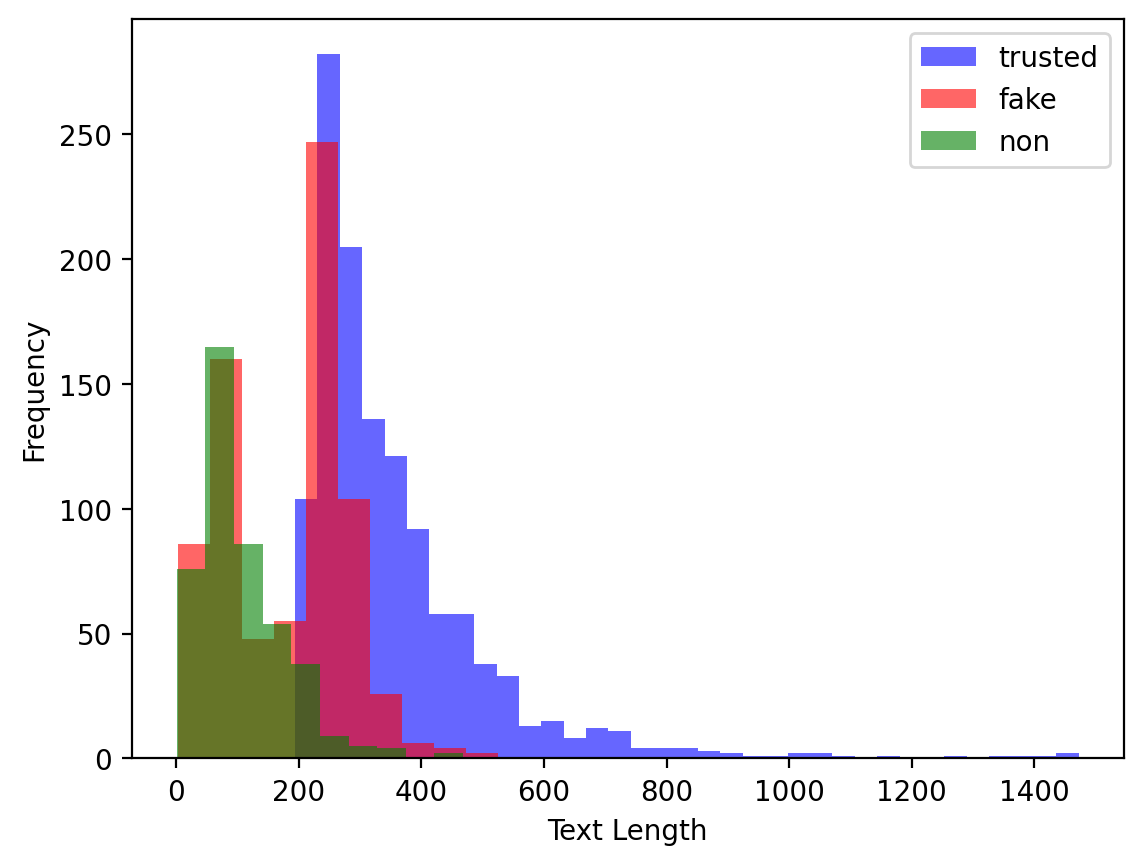

In [125]:
df[df.label=='trusted'].text_length.plot(bins=35, kind='hist', color='blue',
                                       label='trusted', alpha=0.6)
df[df.label == 'fake'].text_length.plot(kind='hist', color='red',
                                       label='fake', alpha=0.6)
df[df.label == 'non'].text_length.plot(kind='hist', color='green',
                                       label='non', alpha=0.6)
plt.legend()
plt.xlabel("Text Length")
plt.show()


In [126]:
df.groupby(['label']).count()

,username,rate,date,sentimen,reviews,produk,text_length
label,,,,,,,
fake,738,738,738,738,738,738,738
non,439,439,439,439,439,439,439
trusted,1217,1217,1217,1217,1217,1217,1217


<Axes: xlabel='label', ylabel='count'>

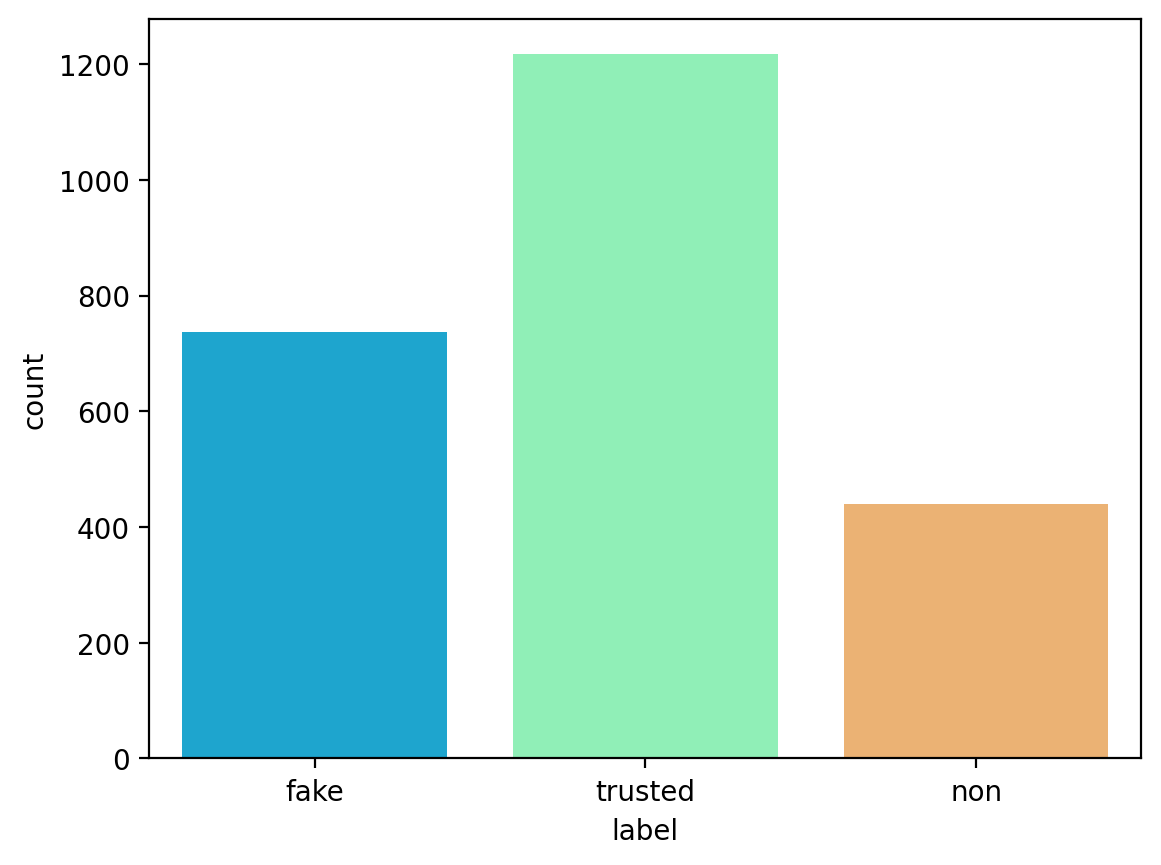

In [127]:
sns.countplot(x='label', data=df, palette='rainbow')

<Axes: xlabel='sentimen', ylabel='count'>

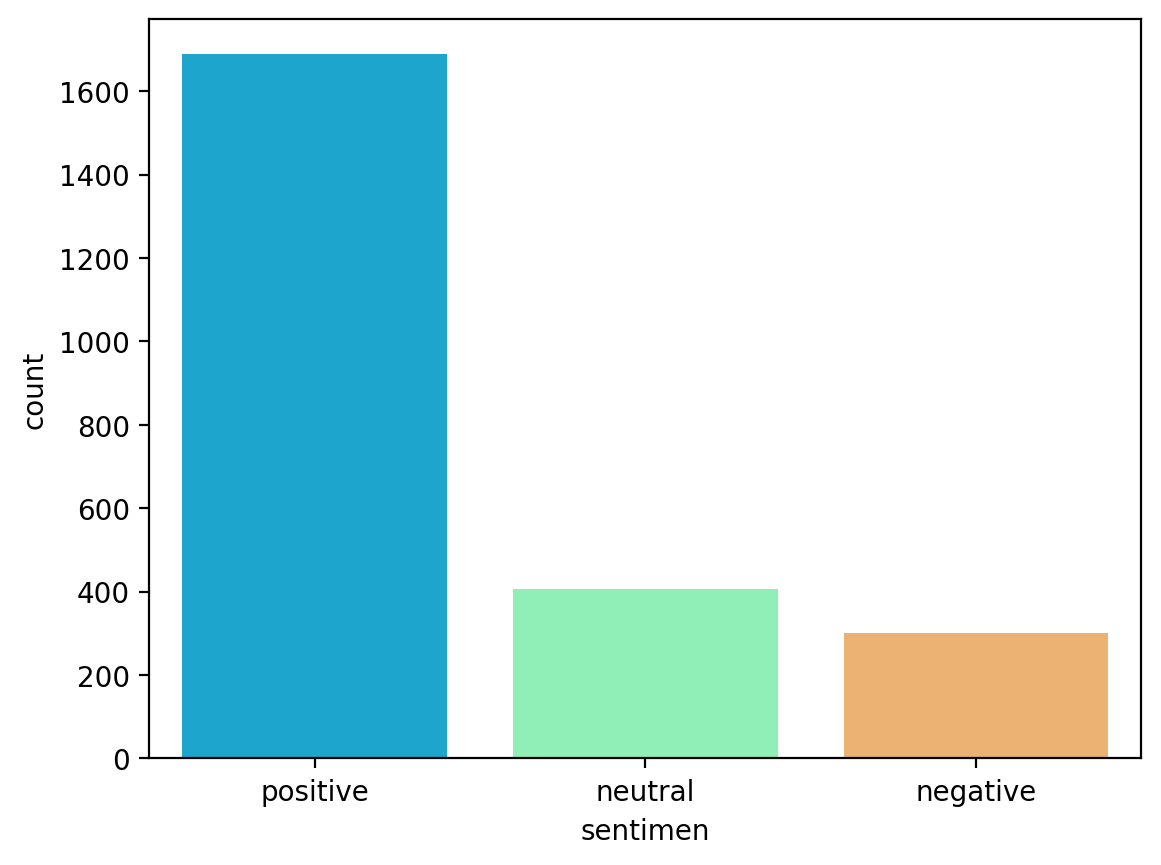

In [128]:
sns.countplot(x='sentimen', data=df, palette='rainbow')

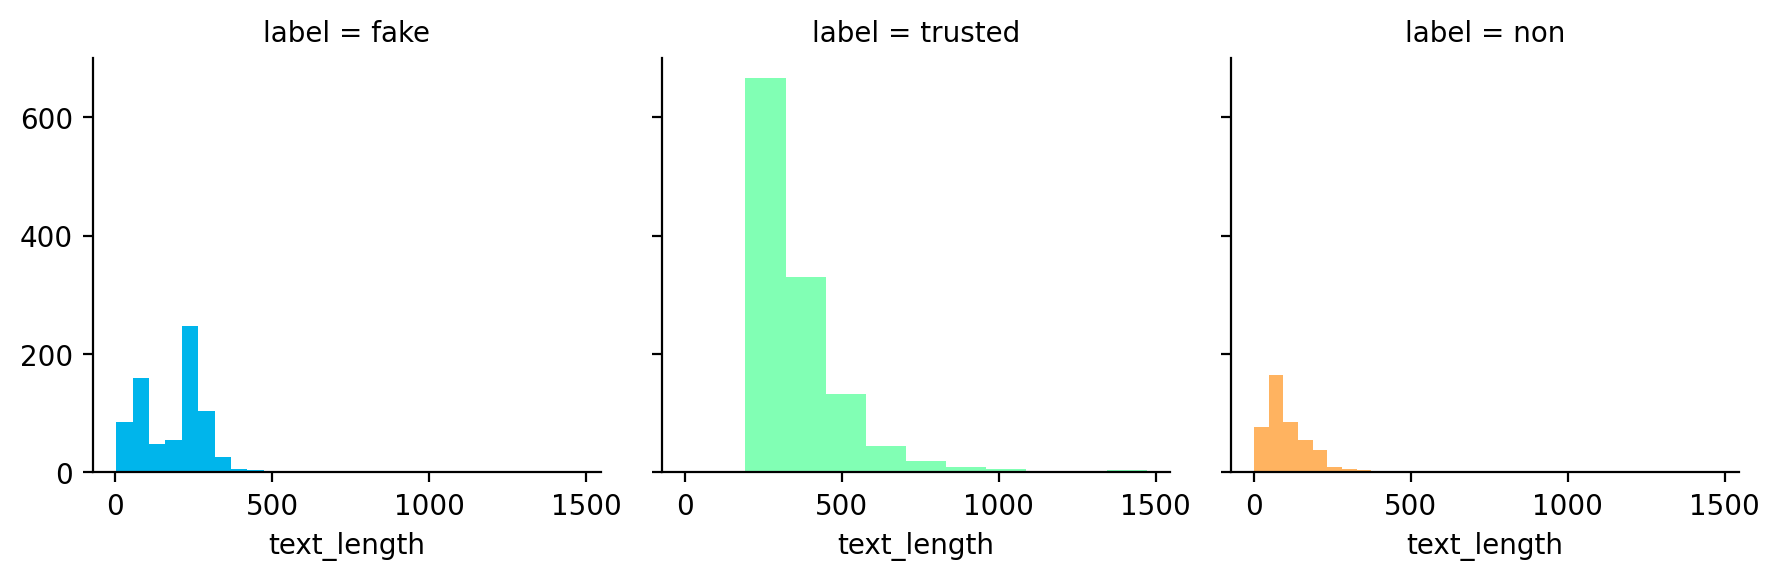

In [129]:
g = sns.FacetGrid(df, col='label', hue='label', palette='rainbow')
g.map(plt.hist, 'text_length')
plt.show()

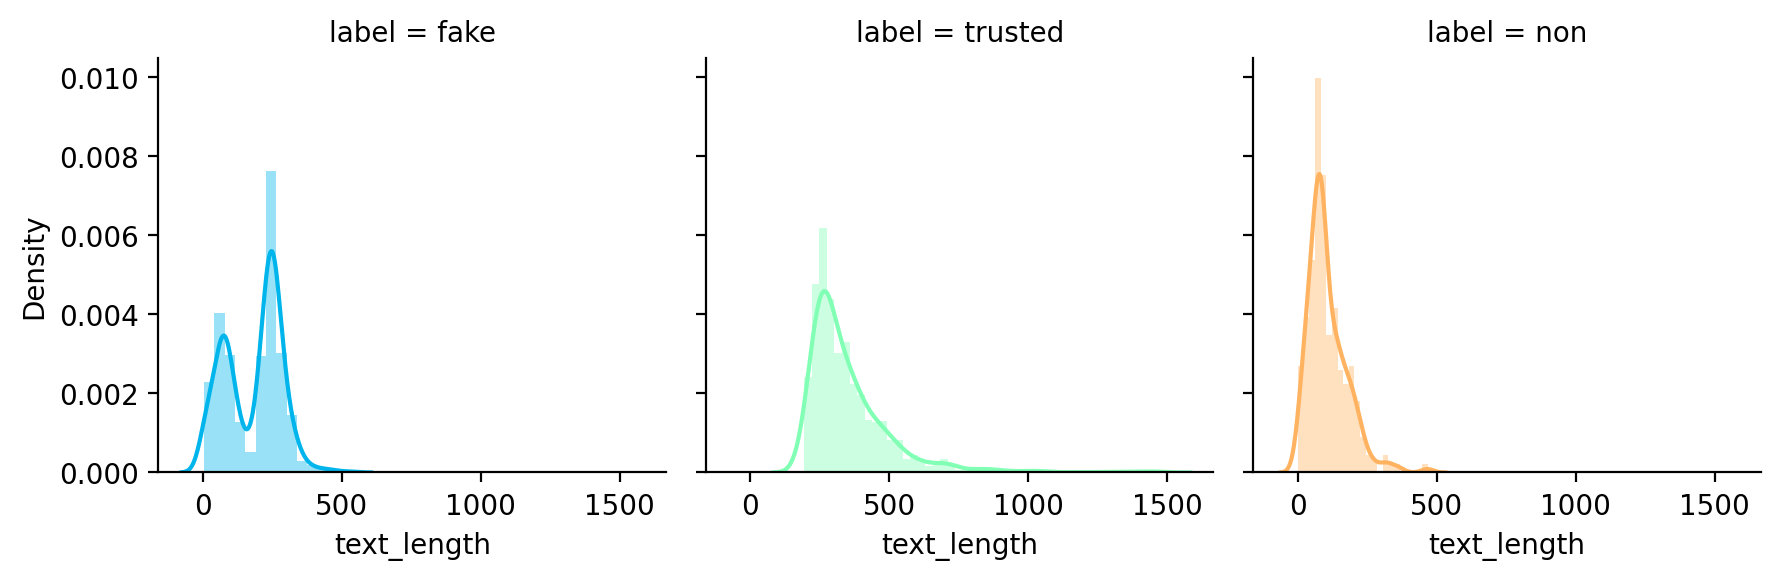

In [130]:
g = sns.FacetGrid(df, col='label', hue='label', palette='rainbow')
g.map(sns.distplot, 'text_length')

<Axes: xlabel='label', ylabel='text_length'>

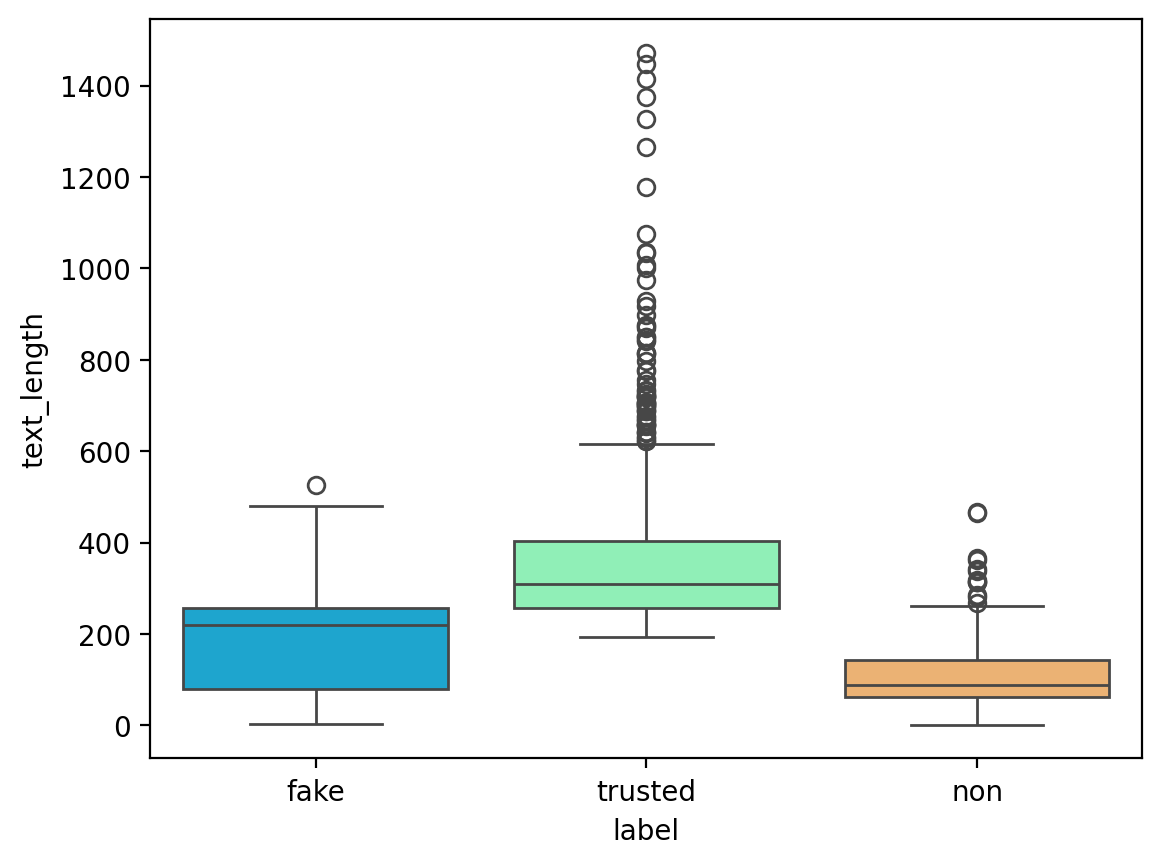

In [131]:
sns.boxplot(x='label',y='text_length',data=df,palette='rainbow')

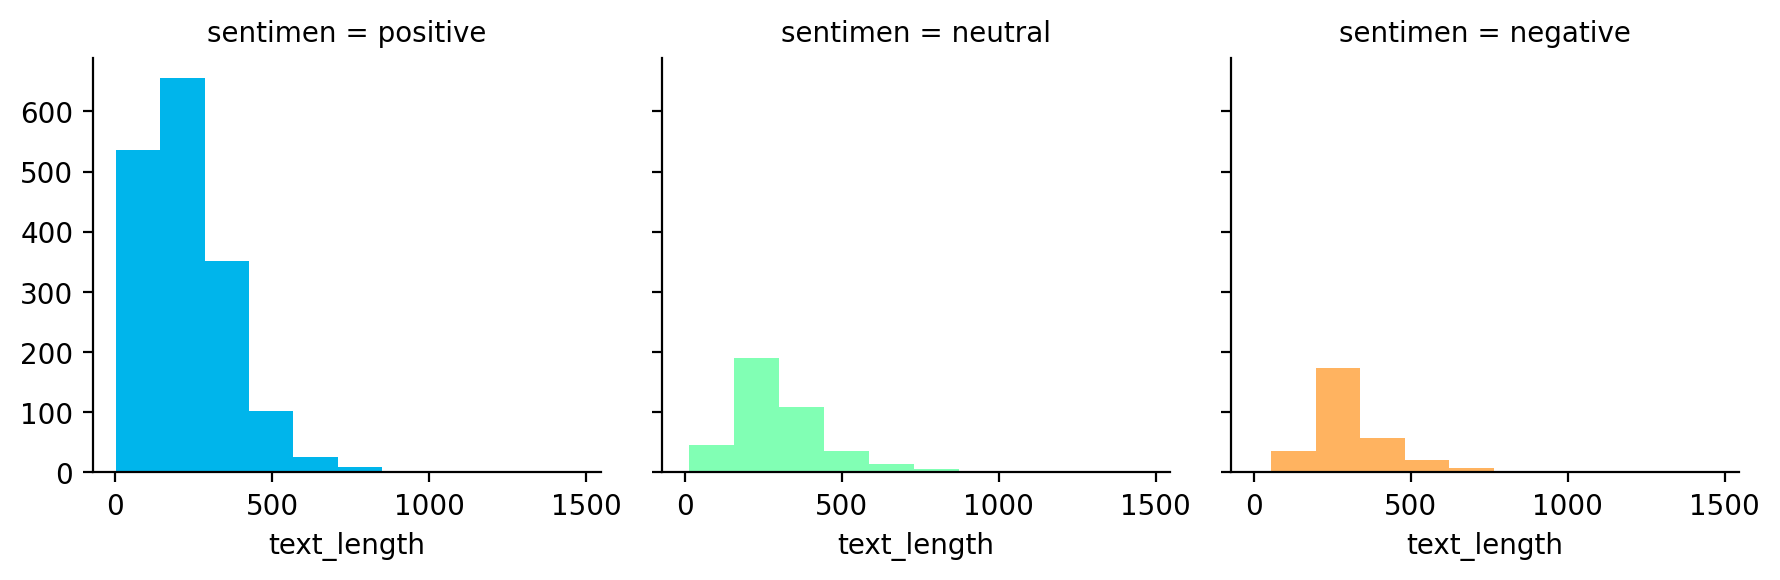

In [132]:
g = sns.FacetGrid(df, col='sentimen', hue='sentimen', palette='rainbow')
g.map(plt.hist, 'text_length')

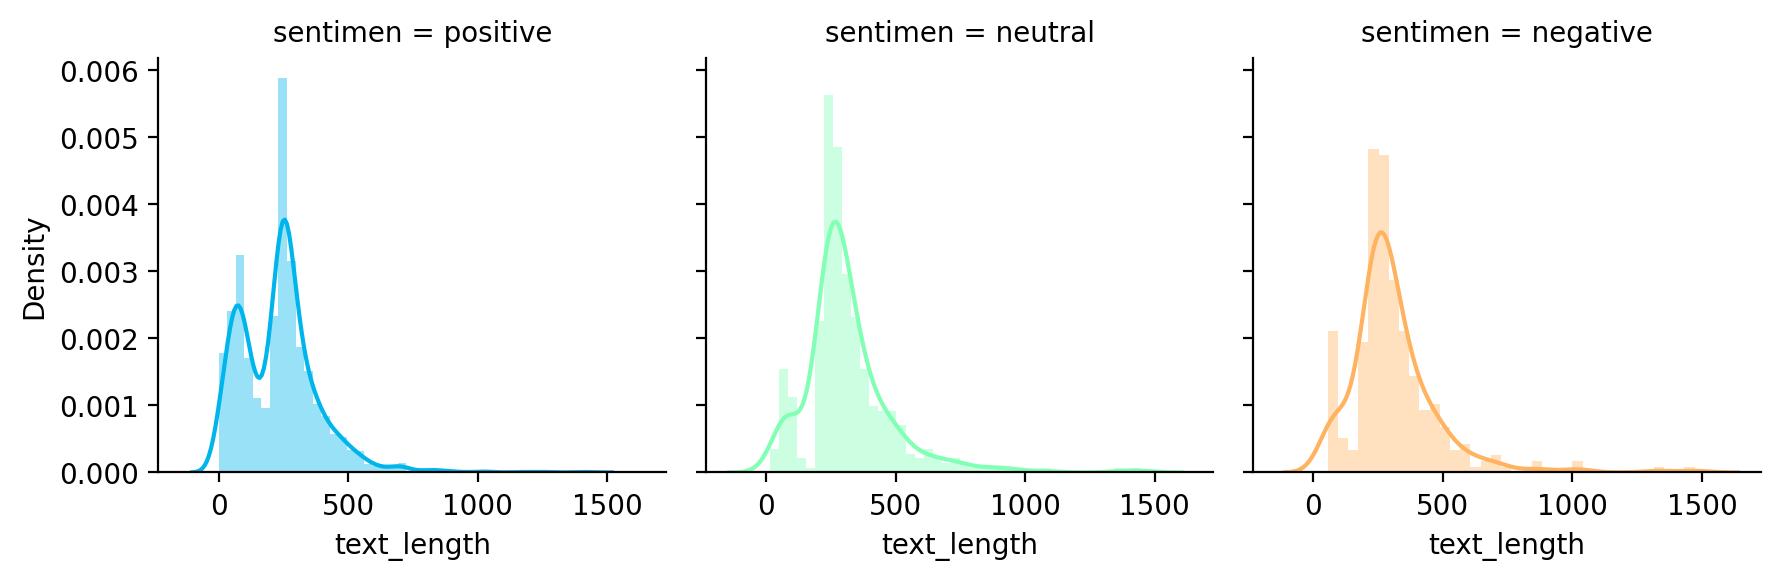

In [133]:
g = sns.FacetGrid(df, col='sentimen', hue='sentimen', palette='rainbow')
g.map(sns.distplot, 'text_length')

<Axes: xlabel='sentimen', ylabel='text_length'>

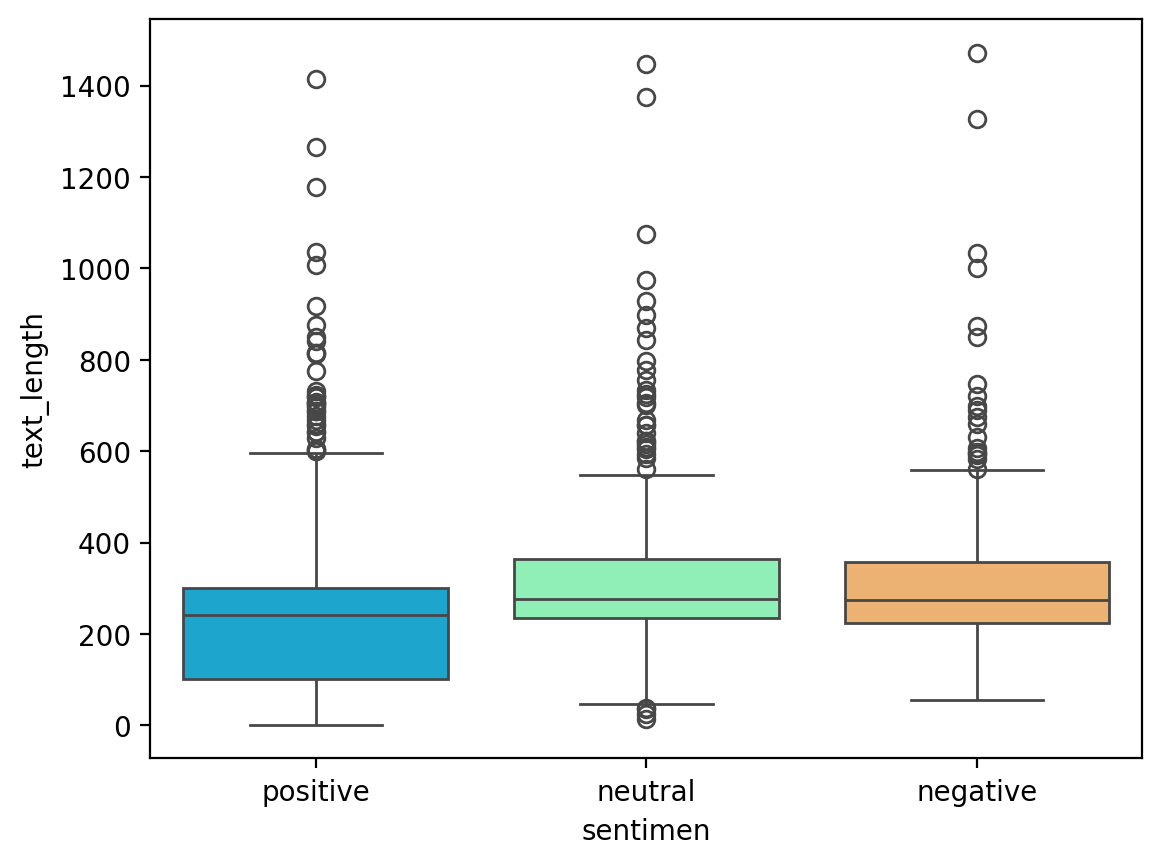

In [134]:
sns.boxplot(x='sentimen',y='text_length',data=df,palette='rainbow')

## Missing Value & Duplicate handling

In [136]:
df.dropna(subset = ["label"], axis=0, inplace=True)

In [137]:
df = df.drop_duplicates()

In [138]:
df['label'].value_counts()

label
trusted    1217
fake        738
non         439
Name: count, dtype: int64

## Outliers Handling



In [139]:
Q1 = df['text_length'].quantile(0.25)
Q3 = df['text_length'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

### Review

<Axes: xlabel='label', ylabel='text_length'>

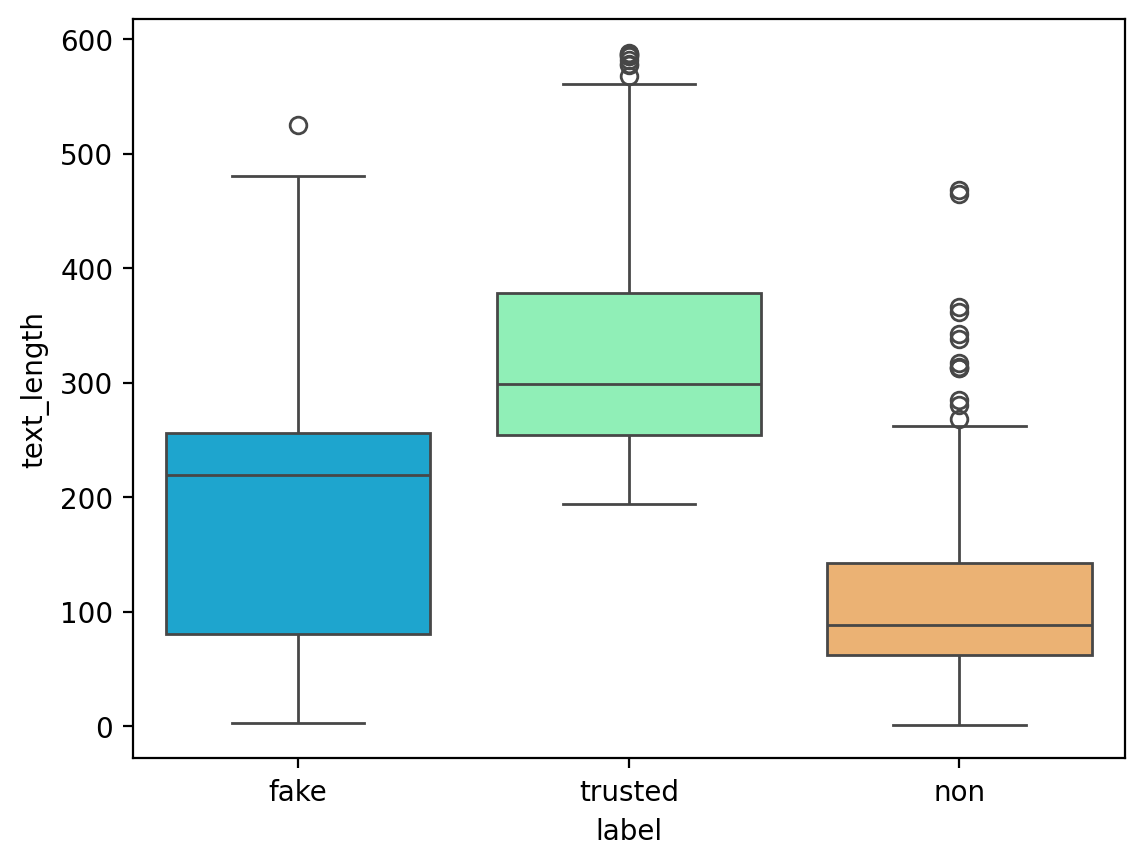

In [140]:
sns.boxplot(x='label',y='text_length',data=df,palette='rainbow')

In [145]:
Q1 = df[df['label'] == 'fake']['text_length'].quantile(0.25)
Q3 = df[df['label'] == 'fake']['text_length'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

In [146]:
Q1 = df[df['label'] == 'trusted']['text_length'].quantile(0.25)
Q3 = df[df['label'] == 'trusted']['text_length'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

In [147]:
Q1 = df[df['label'] == 'non']['text_length'].quantile(0.25)
Q3 = df[df['label'] == 'non']['text_length'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

### Sentimen

<Axes: xlabel='sentimen', ylabel='text_length'>

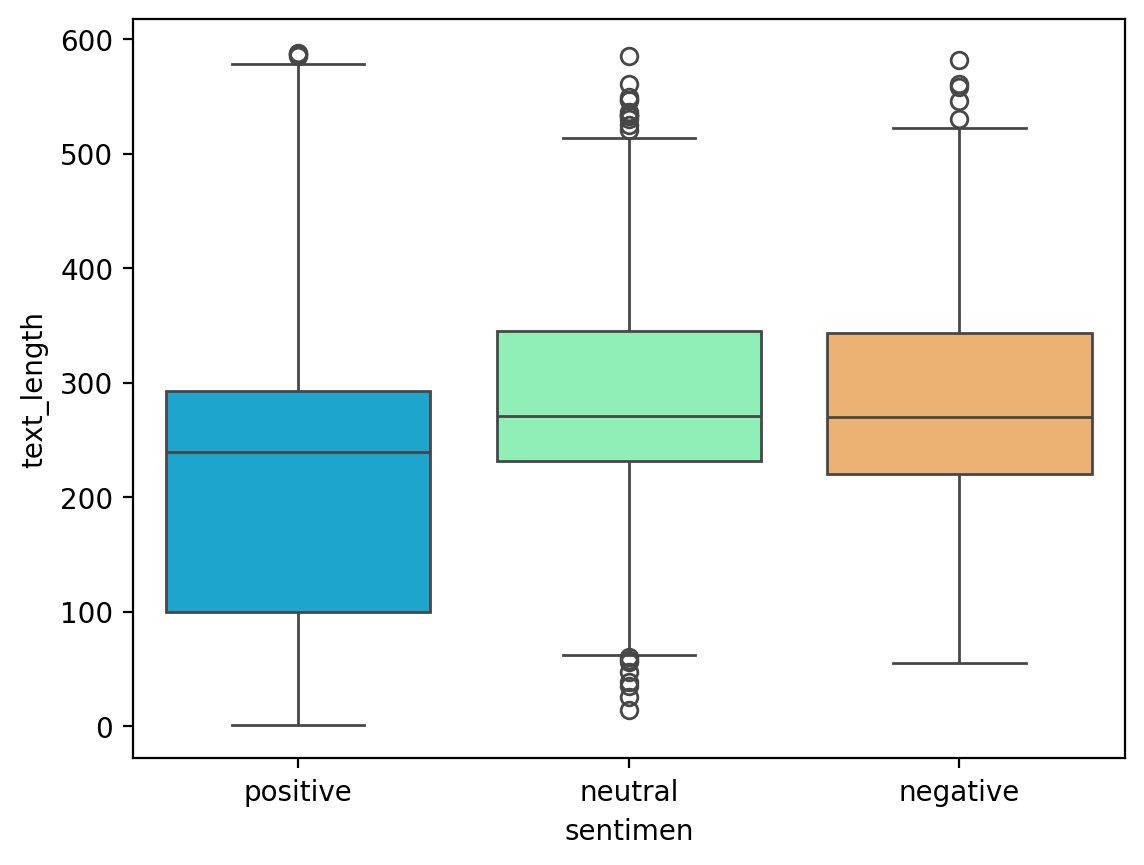

In [142]:
sns.boxplot(x='sentimen',y='text_length',data=df,palette='rainbow')

In [148]:
Q1 = df[df['sentimen'] == 'positive']['text_length'].quantile(0.25)
Q3 = df[df['sentimen'] == 'positive']['text_length'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

In [149]:
Q1 = df[df['sentimen'] == 'negative']['text_length'].quantile(0.25)
Q3 = df[df['sentimen'] == 'negative']['text_length'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

In [150]:
Q1 = df[df['sentimen'] == 'neutral']['text_length'].quantile(0.25)
Q3 = df[df['sentimen'] == 'neutral']['text_length'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

## Show Final Distrubution & Outlier

### Review

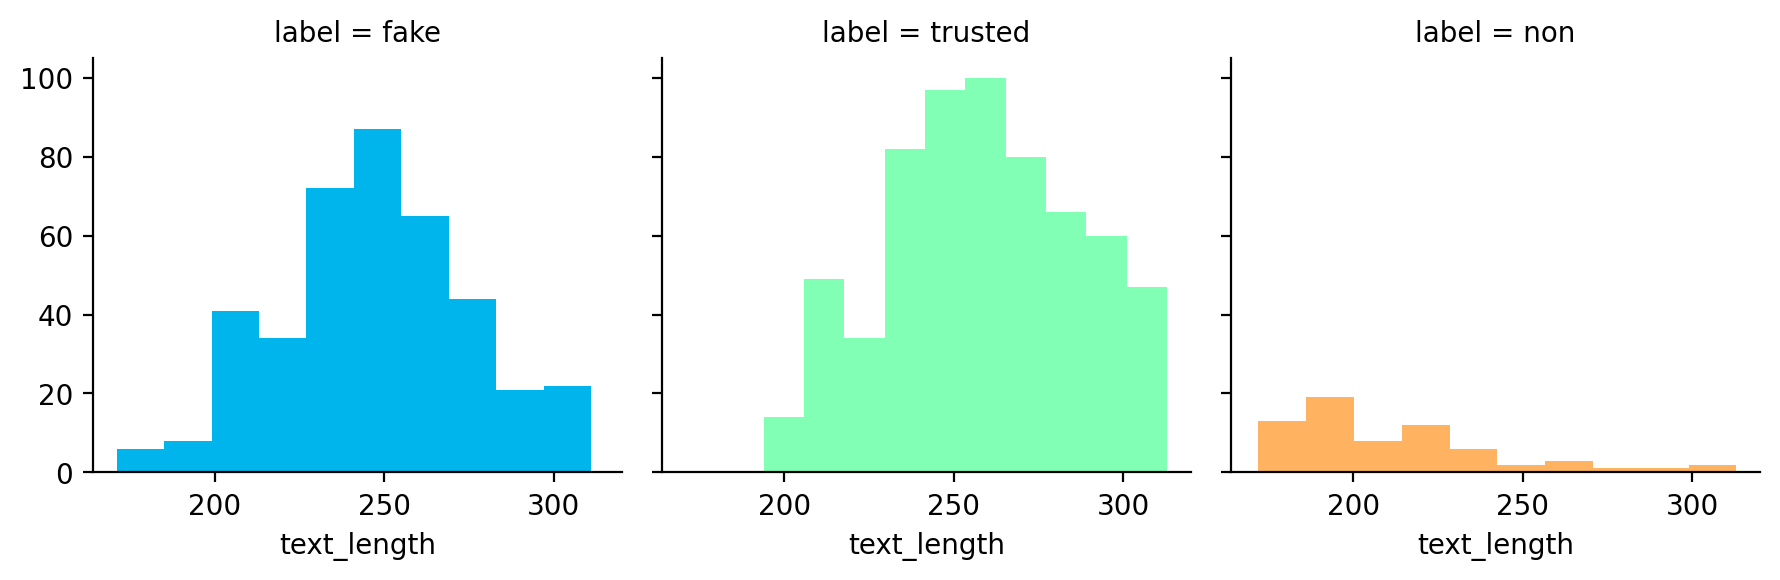

In [151]:
g = sns.FacetGrid(df, col='label', hue='label', palette='rainbow')
g.map(plt.hist, 'text_length')

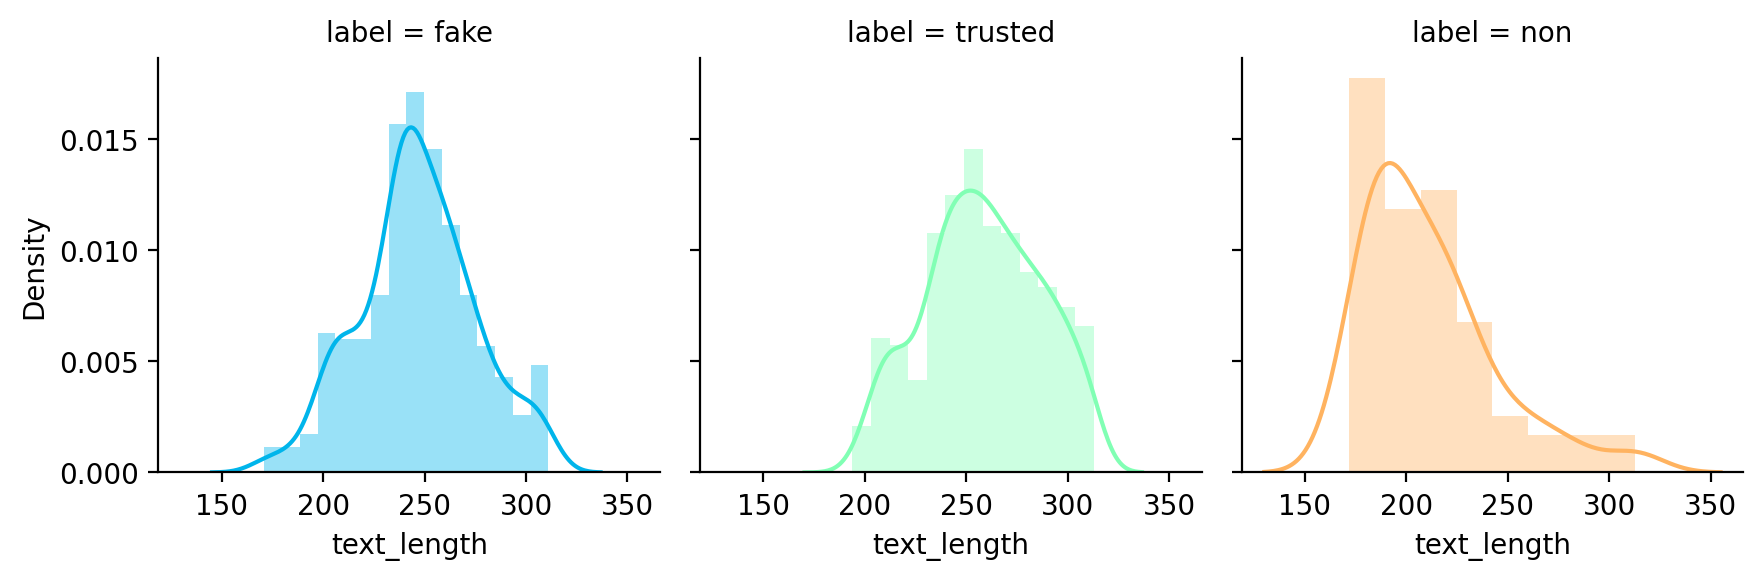

In [154]:
g = sns.FacetGrid(df, col='label', hue='label', palette='rainbow')
g.map(sns.distplot, 'text_length')

<Axes: xlabel='label', ylabel='text_length'>

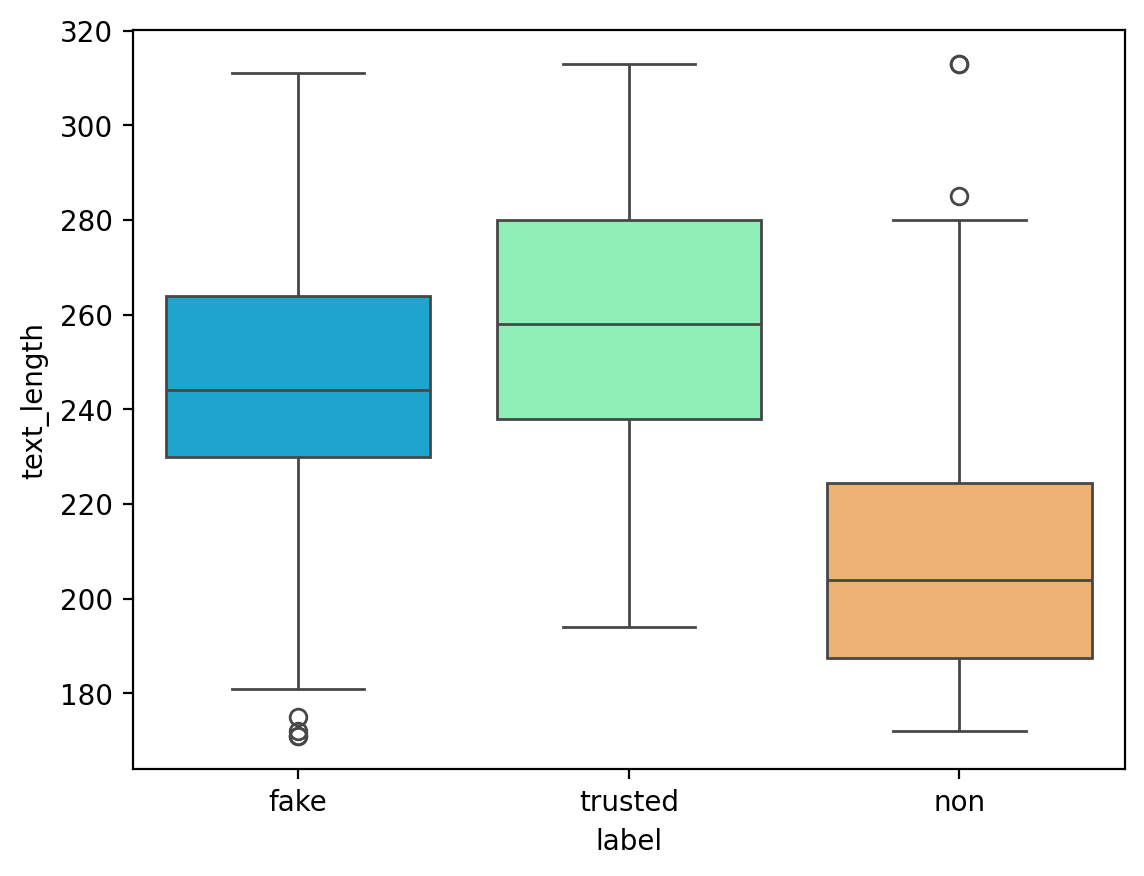

In [155]:
sns.boxplot(x='label',y='text_length',data=df,palette='rainbow')

### Sentimen

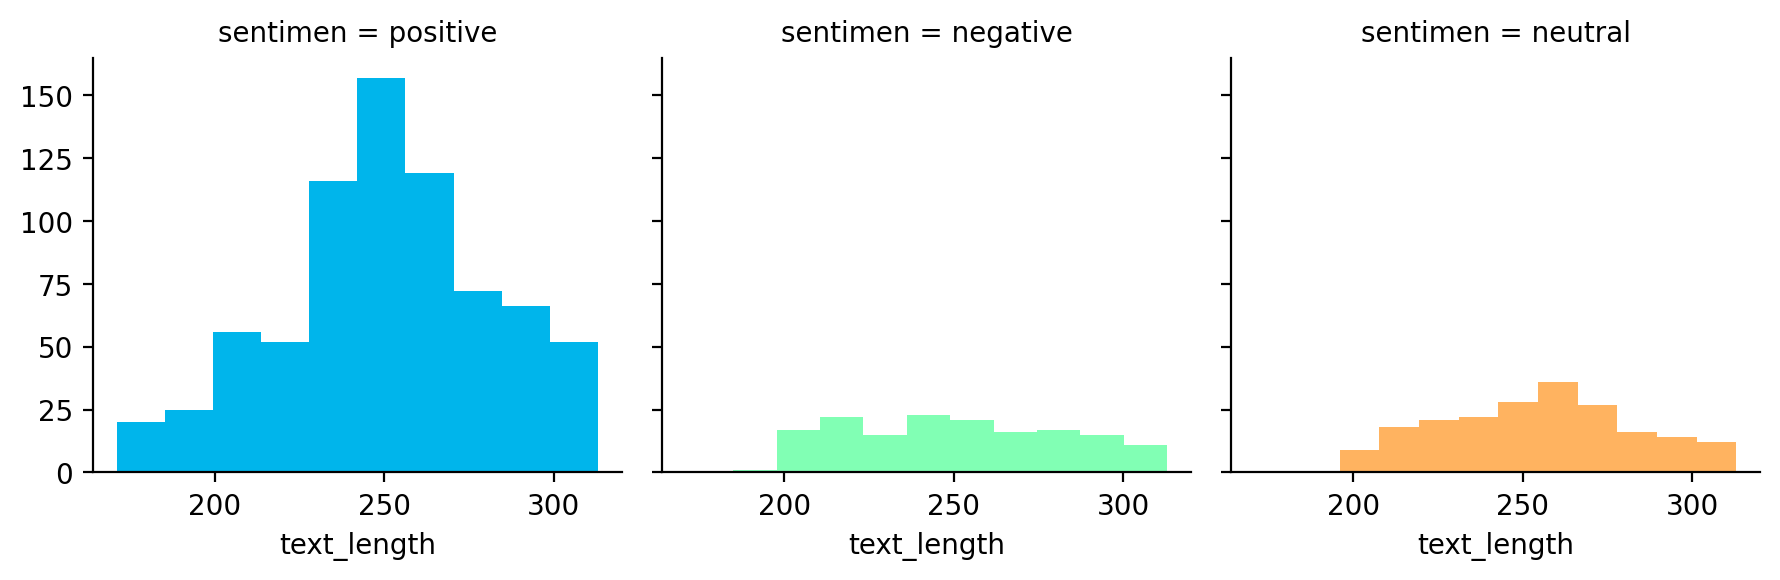

In [153]:
g = sns.FacetGrid(df, col='sentimen', hue='sentimen', palette='rainbow')
g.map(plt.hist, 'text_length')

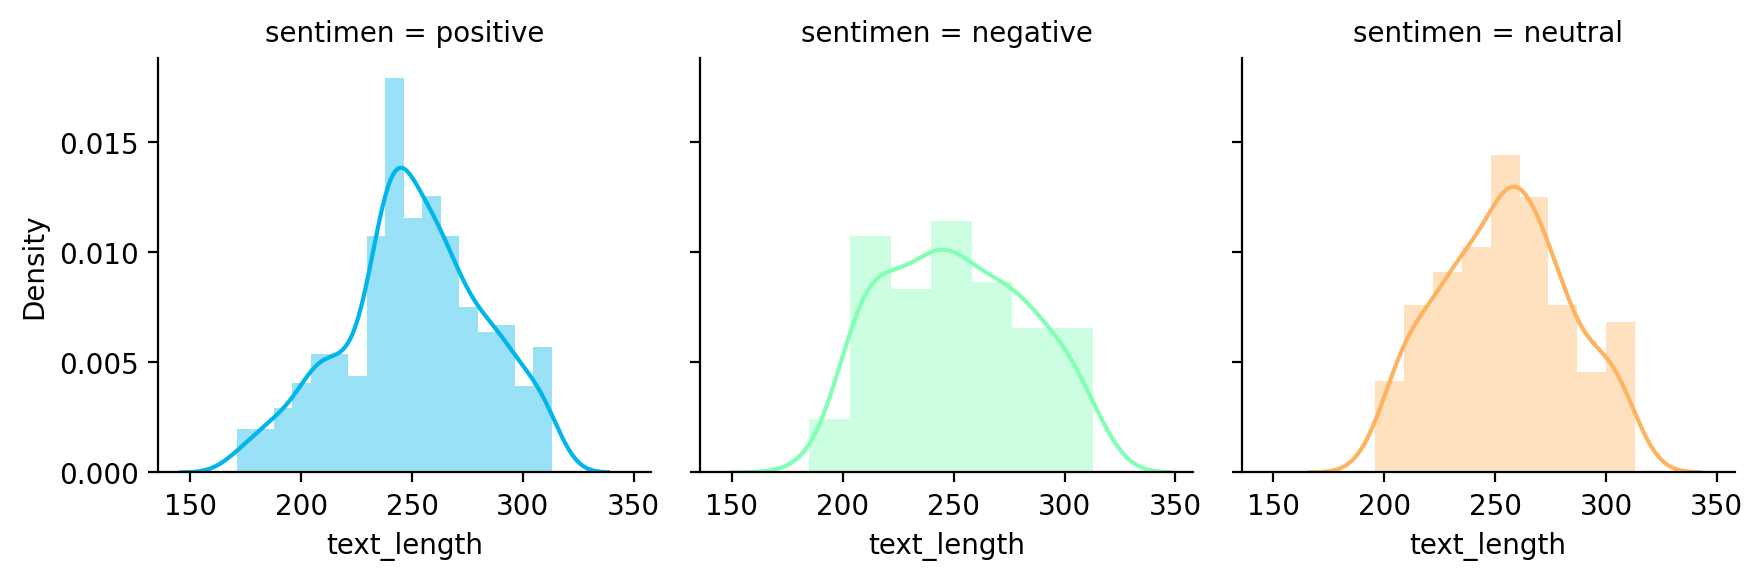

In [156]:
g = sns.FacetGrid(df, col='sentimen', hue='sentimen', palette='rainbow')
g.map(sns.distplot, 'text_length')

<Axes: xlabel='sentimen', ylabel='text_length'>

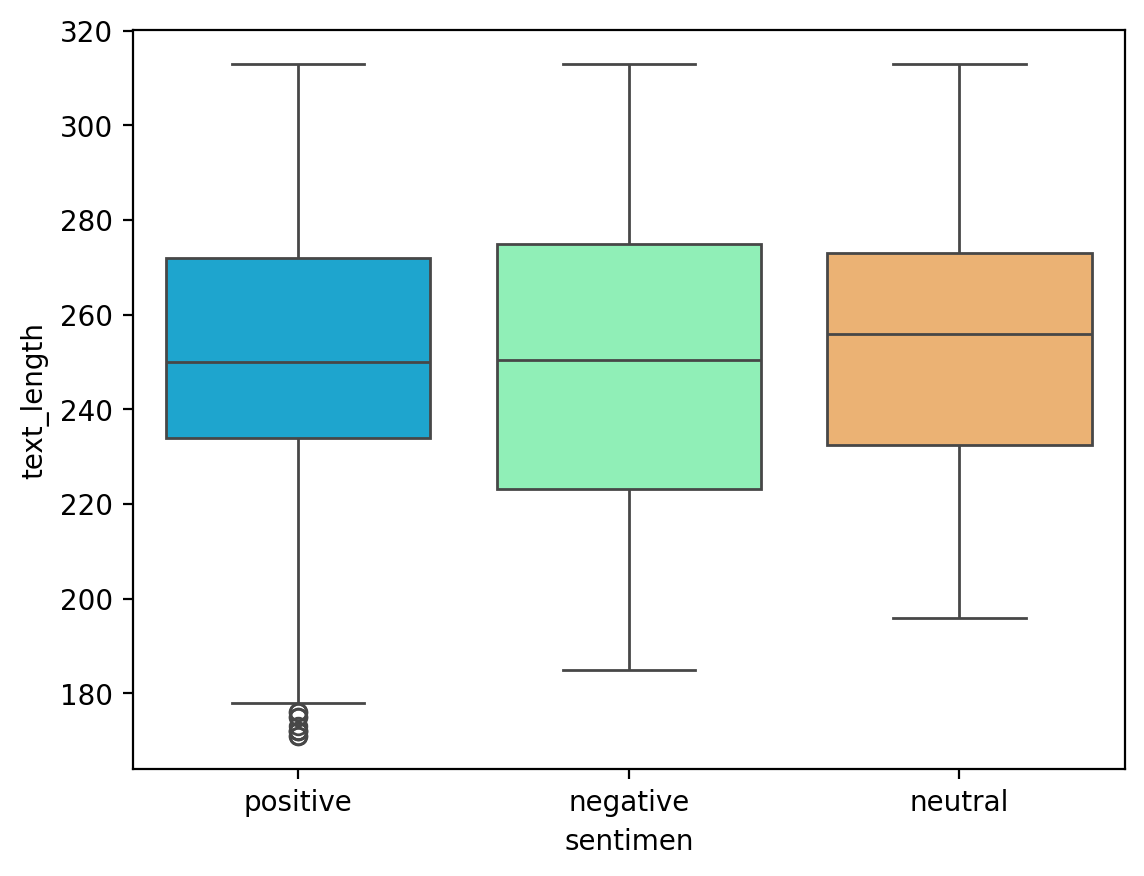

In [157]:
sns.boxplot(x='sentimen',y='text_length',data=df,palette='rainbow')

# Modeling

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec

In [ ]:
# Encode labels
label_encoder_review = LabelEncoder()
label_encoder_sentiment = LabelEncoder()
df['label_encoded'] = label_encoder_review.fit_transform(df['label'])
df['sentiment_encoded'] = label_encoder_sentiment.fit_transform(df['sentimen'])

In [ ]:
# Tokenization and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['reviews'])
sequences = tokenizer.texts_to_sequences(df['reviews'])
word_index = tokenizer.word_index

In [ ]:
# Padding sequences
max_sequence_length = 100  # Adjust as needed
data = pad_sequences(sequences, maxlen=max_sequence_length)

In [ ]:
# Prepare embedding matrix with Word2Vec
w2v_model = Word2Vec(sentences=[text.split() for text in df['reviews']], vector_size=100, window=5, min_count=1, workers=4)
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [ ]:
# Split the data
X_train, X_test, y_train_label, y_test_label, y_train_sentiment, y_test_sentiment = train_test_split(
    data, df['label_encoded'], df['sentiment_encoded'], test_size=0.2, random_state=42
)

In [ ]:
# Define the model
input_ = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=max_sequence_length, trainable=False)
embedding_layer.build((None,))  # Build the embedding layer
embedding_layer.set_weights([embedding_matrix])  # Set the weights of the embedding layer

embedding = embedding_layer(input_)

In [ ]:
# LSTM layer
lstm_out = LSTM(128, return_sequences=True)(embedding)
lstm_out = LSTM(64)(lstm_out)

In [ ]:
# Output layers
output_review = Dense(3, activation='softmax', name='review_output')(lstm_out)
output_sentiment = Dense(3, activation='softmax', name='sentiment_output')(lstm_out)


In [ ]:
# Combine into a model
model = Model(inputs=input_, outputs=[output_review, output_sentiment])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Summary of the model
model.summary()

In [ ]:
# Compile the model with metrics for each output
model.compile(optimizer='adam',
              loss={'review_output': 'sparse_categorical_crossentropy', 'sentiment_output': 'sparse_categorical_crossentropy'},
              metrics={'review_output': 'accuracy', 'sentiment_output': 'accuracy'})

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define Early Stopping and Model Checkpoint callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

In [ ]:
# Train the model with callbacks
history = model.fit(
    X_train,
    {'review_output': y_train_label, 'sentiment_output': y_train_sentiment},
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)

In [ ]:
# Evaluate the model
results = model.evaluate(X_test, {'review_output': y_test_label, 'sentiment_output': y_test_sentiment})
print(f'Test results - Loss: {results[0]} - Review Output Loss: {results[1]} - Sentiment Output Loss: {results[2]}')

In [ ]:
# Print history
print(history.history.keys())


In [ ]:
import matplotlib.pyplot as plt

# Plot learning curve
def plot_learning_curve(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['review_output_accuracy'], label='Review Output Accuracy')
    plt.plot(history.history['val_review_output_accuracy'], label='Validation Review Output Accuracy')
    plt.plot(history.history['sentiment_output_accuracy'], label='Sentiment Output Accuracy')
    plt.plot(history.history['val_sentiment_output_accuracy'], label='Validation Sentiment Output Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot learning curve
plot_learning_curve(history)


In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the test set
y_test_pred_review = np.argmax(model.predict(X_test)[0], axis=1)
y_test_pred_sentiment = np.argmax(model.predict(X_test)[1], axis=1)

# Convert labels back to original encoding
y_test_true_review = y_test_label
y_test_true_sentiment = y_test_sentiment

In [ ]:
# Plot confusion matrix for review prediction
cm_review = confusion_matrix(y_test_true_review, y_test_pred_review)
disp_review = ConfusionMatrixDisplay(confusion_matrix=cm_review, display_labels=label_encoder_review.classes_)
disp_review.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Review Classification')
plt.show()

In [ ]:
# Plot confusion matrix for sentiment prediction
cm_sentiment = confusion_matrix(y_test_true_sentiment, y_test_pred_sentiment)
disp_sentiment = ConfusionMatrixDisplay(confusion_matrix=cm_sentiment, display_labels=label_encoder_sentiment.classes_)
disp_sentiment.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Sentiment Classification')
plt.show()

In [ ]:
# Function for prediction with percentage
def predict_review_with_percentage(model, tokenizer, review_text):
    sequence = tokenizer.texts_to_sequences([review_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    prediction = model.predict(padded_sequence)

    review_pred = label_encoder_review.inverse_transform(np.argmax(prediction[0], axis=1))[0]
    sentiment_pred = label_encoder_sentiment.inverse_transform(np.argmax(prediction[1], axis=1))[0]

    # Calculate percentage
    review_percentage = np.max(prediction[0]) * 100
    sentiment_percentage = np.max(prediction[1]) * 100

    return review_pred, review_percentage, sentiment_pred, sentiment_percentage



# Function to predict star rating based on sentiment percentage
def predict_star_rating(sentiment_percentage):
    if sentiment_percentage <= 20:
        return 1
    elif sentiment_percentage <= 40:
        return 2
    elif sentiment_percentage <= 60:
        return 3
    elif sentiment_percentage <= 80:
        return 4
    else:
        return 5




In [ ]:
# Example usage by user input
user_review = input("Masukkan review produk: ")
review_pred, review_percentage, sentiment_pred, sentiment_percentage = predict_review_with_percentage(model, tokenizer, user_review)

# Predict star rating based on sentiment percentage
star_rating = predict_star_rating(sentiment_percentage)
print('===============================   Review Analysis Result   ====================================')
print(f'Review : {review_pred} - Percentage: {review_percentage:.2f}%')
print(f'Sentiment : {sentiment_pred} - Percentage: {sentiment_percentage:.2f}%')
print(f'Star Rating: {star_rating}')